In [ ]:
#Cambiar los valores para modificar el experimento

experiment = 1 #1-> BANKEX , 2 ->Activities
f = 20 #Tamaño de la ventana a futuro en días. 1 or 20.
thepath = 'sample_data'

Suggested citation: Velarde, G., Brañez, P., Bueno, A., Heredia, R., & Lopez, M. (Accepted). An Open-Source and Reproducible Implementation of GRU and LSTM Networks for Time Series Forecasting. ITISE CONFERENCE: 8th International Conference on Time Series and Forecasting, June 27th-30th, 2022.

MIT License

Copyright (c) [2021] [Gissel Velarde, Pedro Brañez, Alejandro Bueno, Rodrigo Heredia, & Mateo Lopez]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from numpy import genfromtxt
from pandas_datareader import data as pdr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import mannwhitneyu

Definitions

In [ ]:
def GRU_Model(output_window):
  model = Sequential()
  model.add(GRU(128, return_sequences=False, input_shape=(X.shape[1],1)))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

In [ ]:
def LSTM_Model(output_window):
  model = Sequential()
  model.add(LSTM(128, return_sequences=False, input_shape=(X.shape[1],1)))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

In [ ]:
#Basado en: Computer Science: Stock Price Prediction Using Python & Machine Learning. https://www.youtube.com/watch?v=QIUxPv5PJOY (2019), accessed 25 January,
2022
def data_preparation(w, scaled_data, N, f):
  X=[]
  window = w + f
  Q = len(scaled_data)
  for i in range(Q-window+1):
    X.append(scaled_data[i:i+window, 0])

  X = np.array(X)
  X = np.reshape(X, (X.shape[0],X.shape[1],1))

  trainX, trainY = X[0:N,0:w], X[0:N,w:w+f]
  testX, testY = X[N:Q-w,0:w], X[N:Q-w,w:w+f]
  X = trainX
  return trainX, trainY, testX, testY, X

In [ ]:
#Repite el último valor conocido f veces
def baselinef(U,f):
  last = U.shape[0]
  yhat = np.zeros((last, f))
  for j in range(0,last):
    yhat[j,0:f] = np.repeat(U[j,U.shape[1]-1], f)
  return yhat

In [ ]:
#Accuracy direccional (compara la dirección de la predicción con la dirección real)
#From https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9
def mda(actual: np.ndarray, predicted: np.ndarray):
  return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [ ]:
#Normalizar los datos entre 0 y 1
def scaleit(DATAX):
  mima = np.zeros((DATAX.shape[0], 2)) #Guardar valores máximos y mínimos
  for i in range(DATAX.shape[0]):
    mima[i,0],mima[i,1] = DATAX[i,:].min(), DATAX[i,:].max()
    DATAX[i,:] = (DATAX[i,:]-DATAX[i,:].min())/(DATAX[i,:].max()-DATAX[i,:].min())
  return DATAX, mima

In [ ]:
#Reescala los valores originales
def rescaleit(y,mima,i):
  yt = (y*(mima[i,1]-mima[i,0]))+mima[i,0]
  return yt

In [ ]:
#Basado en https://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib
#Para plotear las series en diferentes colores
def plot_series(X):
  x = np.arange(10)
  ys = [i+x+(i*x)**2 for i in range(10)]
  colors = cm.rainbow(np.linspace(0, 1, len(ys)))
  for i in range(10):
    plt.plot(X[i], label='%s ' % (i+1), color=colors[i,:])
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
  plt.xlabel("Days")
  plt.ylabel("Closing Price")

In [ ]:
#Tests estadísticos
def statisticaltests(s):
  print('LSTM and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,1],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and GRU (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,1], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,1+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and GRU (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,1+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))

In [ ]:
if experiment ==1:
  #Usa BANKEX dataset (valor de cierre de bolsa de 10 instituciones finacieras)
  #DATAX = genfromtxt('BANKEX.csv', delimiter=',')
  DATAX = genfromtxt('https://raw.githubusercontent.com/Alebuenoaz/LSTM-and-GRU-Time-Series-Forecasting/refs/heads/main/BANKEX.csv', delimiter=',')

else:
  #Usa Activities dataset
  #DATAX = genfromtxt('activities.csv', delimiter=',')
  DATAX = genfromtxt('https://raw.githubusercontent.com/Alebuenoaz/LSTM-and-GRU-Time-Series-Forecasting/refs/heads/main/activities.csv', delimiter=',')

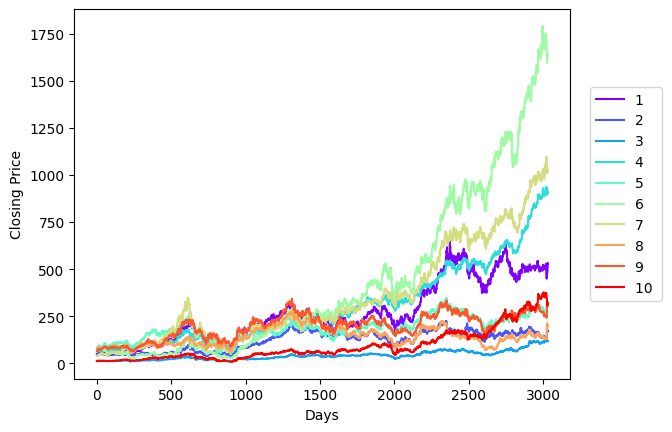

In [ ]:
plot_series(DATAX)

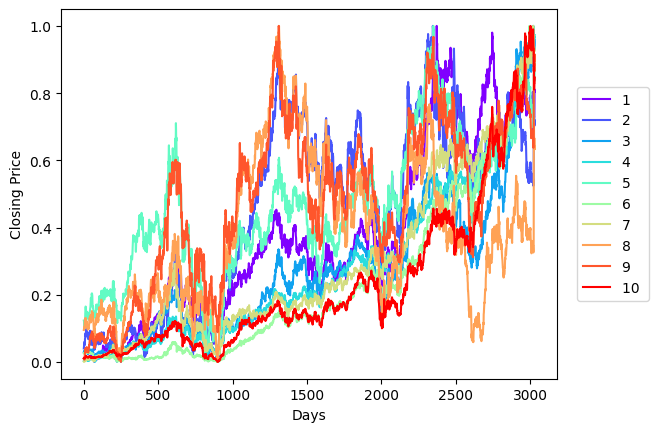

In [ ]:
#Normaliza los datos entre 0 y 1
DATAX, mima = scaleit(DATAX)
plot_series(DATAX)

In [ ]:
selected_series = 0 #Elige arbitrariamente una señal para entrenar el dataset
scaled_data = DATAX[selected_series, :]
scaled_data = np.reshape(scaled_data, (len(scaled_data),1))
scaled_data.shape

(3032, 1)

In [ ]:
#w < N < Q
window = 60 #Tamaño de la ventana en días
test_samples = 251 #Cantidad de muestras
N = len(scaled_data) - test_samples - window

In [ ]:
trainX, trainY, testX, testY, X = data_preparation(window, scaled_data, N,f)

In [ ]:
lstm_model = LSTM_Model(f)
gru_model = GRU_Model(f)
epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,140 (270.08 KB)

 Trainable params: 69,140 (270.08 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 128)                 │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,884 (206.58 KB)

 Trainable params: 52,884 (206.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenar modelo LSTM
lstm_trained = lstm_model.fit(trainX, trainY, shuffle=True, epochs=epochs)
# Entrenar modelo GRU
gru_trained = gru_model.fit(trainX, trainY, shuffle=True, epochs=epochs)

Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0467
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0029
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - loss: 0.0026
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0025
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0022
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0021
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0019
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0018
Epoch 9/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0017
Epoch 10/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0017
Epoch 11/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.0016
Epoch 12/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0016
Epoch 13/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0016
Epoch 14/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0015
Epoch 15/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/

In [ ]:
#Testing
s=(10,6)
s=np.ones(s)  #Para guardar resultados

for j in range(0,10):
  scaled_data = DATAX[j, :] #Cambiar el index en las series de tiempo
  scaled_data = np.reshape(scaled_data, (len(scaled_data),1))
  scaled_data.shape
  _ , _ , testX, testY, _ = data_preparation(window, scaled_data, N, f)
  y_pred_lstm = lstm_model.predict(testX)
  y_pred_gru = gru_model.predict(testX)
  y_baseline = baselinef(testX,f)
  testY = np.reshape(testY, (testY.shape[0],testY.shape[1]))
  print(testY.shape)
  s[j,0] = np.sqrt(mean_squared_error(testY, y_pred_lstm))
  s[j,1] = np.sqrt(mean_squared_error(testY, y_pred_gru))
  s[j,2] = np.sqrt(mean_squared_error(testY, y_baseline))
  s[j,0+3] = mda(testY, y_pred_lstm)
  s[j,1+3] = mda(testY, y_pred_gru)
  s[j,2+3] = mda(testY, y_baseline)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
(232, 20)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
(232, 20)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(232, 20)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(232, 20)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(232, 20)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(232, 20)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(232, 20)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(232, 20)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(232, 20)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(232, 20)


In [ ]:
print('Valores medios')
np.mean(s, axis=0)

In [ ]:
print('Desvío estándar')
np.std(s, axis=0)

Standard Deviation


array([0.00808259, 0.00833634, 0.01130637, 0.01110447, 0.01056377,
       0.00765209])

In [ ]:
#Pruebas estadísticas
statisticaltests(s)

LSTM and Baseline (RMSE)
U=88.0. p = 0.004586392080253494
GRU and Baseline (RMSE)
U=95.0. p = 0.0007685389131627665
LSTM and GRU (RMSE)
U=33.0. p = 0.21229383619233155
LSTM and Baseline (DA)
U=46.5. p = 0.8204630988382954
GRU and Baseline (DA)
U=59.5. p = 0.4959675729800952
LSTM and GRU (DA)
U=36.5. p = 0.3255694067409992


In [ ]:
#Re-escalar para visualización
testY = rescaleit(testY,mima,j)
y_pred_lstm = rescaleit(y_pred_lstm,mima,j)
y_pred_gru = rescaleit(y_pred_gru,mima,j)
y_baseline = rescaleit(y_baseline,mima,j)

In [ ]:
if f == 1:
  plt.plot(testY[0:100], label = 'Actual')
  plt.plot(y_baseline[0:100], label = 'Predicción de base')
  plt.plot(y_pred_lstm[0:100], label = 'Predicción LSTM')
  plt.plot(y_pred_gru[0:100], label = 'Predicción GRU')

  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=True, ncol=5)
  #plt.legend()
  plt.xlabel("Days")
  if experiment ==1:
    plt.ylabel("Precio de cierre")
  else:
    plt.ylabel("Valor")

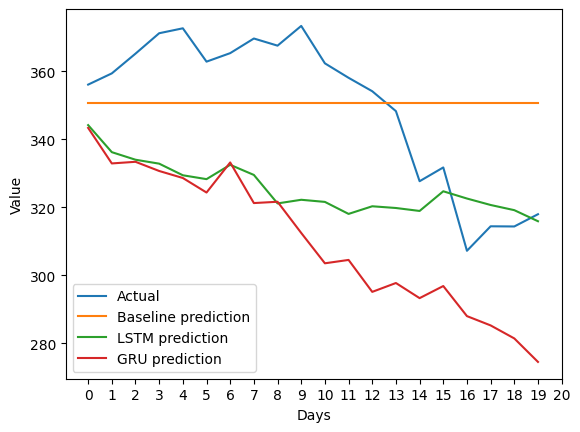

In [ ]:
g = 230 #Chooses one of the tests samples
if f == 20:
  plt.plot(testY[g,:], label = 'Actual')
  plt.plot(y_baseline[g,:], label = 'Predicción de base')
  plt.plot(y_pred_lstm[g,:], label = 'Predicción LSTM')
  plt.plot(y_pred_gru[g,:], label = 'Predicción GRU')
  plt.legend()
  plt.xlabel('Días')
  days = np.arange(testY.shape[1]+1)
  new_list = range(math.floor(min(days)), math.ceil(max(days))+1)
  plt.xticks(new_list)
  plt.ylabel('Valor')

Text(0, 0.5, 'MSE Loss')

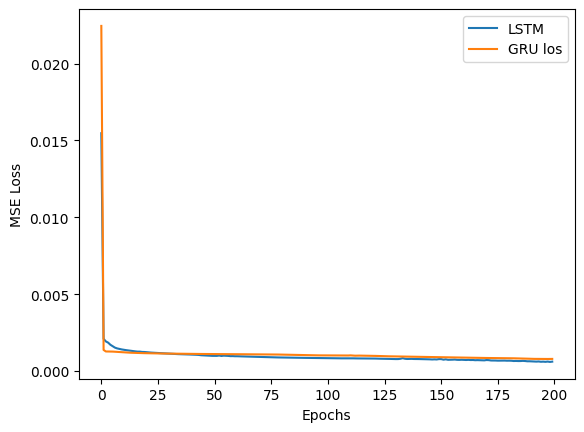

In [ ]:
#"""Grafica funciones de error y predicciones"""
plt.plot(lstm_trained.history['loss'], label = 'LSTM')
plt.plot(gru_trained.history['loss'], label = 'GRU')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Error en MSE')